# Universidade Federal do Rio Grande do Sul
### Alunos: Matheus Westhelle e Dieu Merci Kengele


## Florestas Aleatórias

### Implementação da árvore de decisão

Nossa implementação de árvore consiste de uma classe _TreeNode_, que é apenas uma estrutura de dados que armazena as propriedades de um nodo, e de uma classe _DecisionTree_, encarregada por toda a funcionalidade relacionada à geração da árvore de decisão: do cálculo de entropia, à função recursiva de construção de árvore.

#### Classe TreeNode

Essa classe é a estrutura de dados que armazena informações de um nodo. Em nosso caso, essas informações são
`attribute_data_dict`, um dicionário cujas chaves são os atributos da árvore e cujos valores são os valores desses
atributos; `outcomes`, uma lista de resultados associados aos atributos, de forma que o primeiro elemento de `outcomes` é
a classe relativa aos primeiros elementos das listas de atributos; `children`, uma lista de classes `TreeNode` que representa os nodos filhos desse nodo; `class_`, que representa a classe do nodo, se ele for um nodo folha; `cutting_point_attribute_val`, uma estrutura que armazena o nome do melhor atributo, seu valor, e o ganho de informação desse atributo; e `idx2attr`, uma estrutura auxiliar que mapeia índices aos nomes dos atributos.

#### Classe DecisionTree

A classe `DecisionTree` concentra toda a funcionalidade de geração de árvore de decisão. Nela, implementamos o algoritmo C4.5 como critério de seleção de atributos.

#### Classificação de novas instâncias

Para classificar novas instâncias, a classe `DecisionTree` tem um método `predict` para fazer a classificação de instâncias. Esse método faz um pré-processamento do dado de teste, carregando-o numa estrutura auxiliar contendo os nomes dos atributos, e chama outro método recursivo, `_predict`. A recursão tem dois casos base: o primeiro ocorre quando o nodo tem uma classe, o que, na nossa implementação, significa que ele é um nodo folha. O outro ocorre quando não existem mais atributos para particionarmos; nesse caso, retornamos a classe majoritária. A recursão segue buscando o melhor atributo de acordo com a razão de ganho (previamente armazenado na construção da árvore) e comparando o valor armazenado em `cutting_point_attribute_val` de cada filho do nodo atual com o valor da instância; se os valores forem iguais, removemos o atributo de uma estrutura auxiliar, `available_attrs`, e seguimos a recursão com o filho e os atributos restantes.

Empiricamente, descobrimos que, ao gerar árvores aleatórias com bootstraps, algumas árvores não contem exemplos de todos os valores possíveis de atributos. Nosso método de construção de árvore não gera folhas vazias nesse caso, então o que fizemos é, ao encontrarmos um valor de atributo não "visto" até o momento, paramos a recursão e retornamos a classe majoritária.

### Florestas aleatórias

Nossa classe `RandomForest` funciona como um modelo ensemble genérico, que recebe outro modelo como parâmetro (esse modelo é subclasse de uma classe abstrata que implementa os métodos `fit` e `predict`). A própria classe `RandomForest` também implementa os métodos `fit` e `predict`; o seu método `fit` gera `ntree` instâncias do modelo recebido, que é nossa árvore de decisão, e os treina a partir de bootstraps dos dados, de forma que cada árvore é treinada com um bootstrap diferente. Outro fator que varia de árvore para árvore são os atributos selecionados. Nós escolhemos um número de atributos que é a raiz quadrada do número de atributos dos dados originais, arredondado para baixo, como é sugerido na especificação do trabalho; não tentamos otimizar esse parâmetro.

Após treinarmos todas as instâncias do modelo, podemos gerar predições. O método `predict` da classe gera uma predição para cada modelo; nós então agrupamos essas predições e geramos a predição final do modelo a partir de uma votação majoritária.

### Validação cruzada

Para avaliação do modelo, nós usamos validação cruzada com 10 folds, sem repetição.
A implementação dessa avaliação se encontra na classe `KFoldCrossValidation`. Ela armazena uma lista de índices através 
dos quais ela faz a leitura do arquivo do dataset, e essa lista é manipulada para gerarmos os folds de treinamento e teste.
A lista de indíces é criada através do método `index_dataset`, e cada fold é gerado pelo método `generate_stratified_fold`;
esse método gera um fold através de amostragem estratificada, usando as proporções das classes como peso para amostragem.

É feita a avaliação do modelo fazendo um _fit_ com os folds de treinamento e _predict_ com o fold de teste. Comparamos as predições geradas pelo _predict_ com os resultados reais e, a partir dessa comparação, geramos a métrica de acurácia. Há de ser feita a consideração de que essa métrica usualmente não é muito boa, especialmente para datasets desbalanceados.

### Experimentos

In [2]:
from collections import defaultdict
from functools import partial
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from decision_tree import DecisionTree
from random_forest import RandomForest
from kfold_crossvalidation import KFoldCrossValidation
%matplotlib inline

#### Análise de corretude com o dataset benchmark

Para analisarmos a corretude da nossa implementação de árvore de decisão, criamos um método simples de impressão, que ajusta a indentação de acordo com o nível da recursão, e imprime o atributo de corte e o ganho de informação. Abaixo, inicializamos uma instância do nosso modelo; carregamos um dataset toy, provido a nós pelos professores; treinamos o modelo nesses dados e imprimimos a árvore gerada.

In [3]:
dec_tree = DecisionTree()
with open("../datasets/benchmark.csv") as benchmark:
    data = []
    next(benchmark) #skip header
    for line in benchmark:
        data.append(line.strip().split(";"))
    dec_tree.fit(data, attribute_names=["Tempo", "Temperatura", "Umidade", "Ventoso"])
    dec_tree.print_tree(dec_tree.root)

 Tempo 0.2467498197744391
   Ventoso 0.9709505944546686
     Ventoso 0.9709505944546686
   Tempo 0.2467498197744391
     Tempo 0.2467498197744391
       Umidade 0.9709505944546686
         Umidade 0.9709505944546686


Os pontos de corte e valores do ganho de informação batem com os valores do exemplo, portanto podemos concluir que nossa implementação de árvore de decisão funciona como o esperado.

#### Balanceamento de classes por dataset

In [20]:
from collections import Counter

class_counter = Counter()

with open("../datasets/house_votes_84.tsv") as house_votes:
    next(house_votes)
    for line in house_votes:
        target = line.strip().split('\t')[-1]
        class_counter[target] += 1

print(class_counter)

Counter({'0': 267, '1': 168})


In [22]:
class_counter = Counter()

with open("../datasets/wine_recognition.tsv") as house_votes:
    next(house_votes)
    for line in house_votes:
        target = line.strip().split('\t')[-1]
        class_counter[target] += 1

print(class_counter)

Counter({'2': 71, '1': 59, '3': 48})


O dataset _house_votes_84_ apresenta certo desbalanço entre as classes-alvo, enquanto o dataset _wine_recognition_ apresenta um desbalanço menor, mas ainda presente.

#### Avaliação do modelo nos datasets

Ao escolhermos o número de árvores a serem usadas no modelo, devemos levar em consideração o número de classes no dataset, a fim de evitar a possibilidade de empates na votação. O número de árvores deve, então, ter módulo _k_ diferente de 0, onde _k_ é o número de classes no dataset. O dataset _House Votes 84_ tem apenas duas classes, de forma que basta usarmos um número ímpar de árvores. Já o dataset _Wine Recognition_ tem três possíveis classes, o que significa que não iremos usar números de árvore múltiplos de três. Optamos então por usar números primos de árvores para realizarmos nossos experimentos.

Poderia ser argumentado, entretanto, que em caso de empate de votação, o modelo está realmente "indeciso" e poderíamos então escolher uma classe ao acaso.

In [12]:
results = defaultdict(dict)

datasets = ["house_votes_84", "wine_recognition"]

random_forest_categorical = partial(RandomForest, model=DecisionTree())
random_forest_numerical = partial(RandomForest, model=DecisionTree(numerical=True))

start = time.time()

for dataset in datasets:
    for i in [1, 5, 7, 11, 17, 23, 31, 37, 53]:
        print(f"Cross-validating {i} trees")
        print("=========================")
        if dataset == "house_votes_84":
            kfold = KFoldCrossValidation(random_forest_categorical(ntrees=i), delimiter="\t")
        else:
            kfold = KFoldCrossValidation(random_forest_numerical(ntrees=i), delimiter="\t")
        results[dataset][f"ntbrees-{i}"] = kfold.kfold_cross_validation(
            os.path.join(os.getcwd(), "../datasets", f"{dataset}.tsv")
        )

end = time.time()
print(f"Cross-validation took {end - start:.2f}s")

Cross-validating 1 trees
Fold 1 accuracy: 72.09%
Fold 2 accuracy: 81.40%
Fold 3 accuracy: 83.72%
Fold 4 accuracy: 90.70%
Fold 5 accuracy: 90.70%
Fold 6 accuracy: 85.42%
Fold 7 accuracy: 86.05%
Fold 8 accuracy: 90.70%
Fold 9 accuracy: 93.02%
Fold 10 accuracy: 88.37%
Mean accuracy: 86.22%
Cross-validating 5 trees
Fold 1 accuracy: 95.35%
Fold 2 accuracy: 97.67%
Fold 3 accuracy: 97.67%
Fold 4 accuracy: 95.35%
Fold 5 accuracy: 97.67%
Fold 6 accuracy: 87.50%
Fold 7 accuracy: 88.37%
Fold 8 accuracy: 88.37%
Fold 9 accuracy: 93.02%
Fold 10 accuracy: 88.37%
Mean accuracy: 92.94%
Cross-validating 7 trees
Fold 1 accuracy: 90.70%
Fold 2 accuracy: 100.00%
Fold 3 accuracy: 97.67%
Fold 4 accuracy: 95.35%
Fold 5 accuracy: 97.67%
Fold 6 accuracy: 89.58%
Fold 7 accuracy: 90.70%
Fold 8 accuracy: 88.37%
Fold 9 accuracy: 97.67%
Fold 10 accuracy: 93.02%
Mean accuracy: 94.07%
Cross-validating 11 trees
Fold 1 accuracy: 86.05%
Fold 2 accuracy: 97.67%
Fold 3 accuracy: 95.35%
Fold 4 accuracy: 97.67%
Fold 5 accura

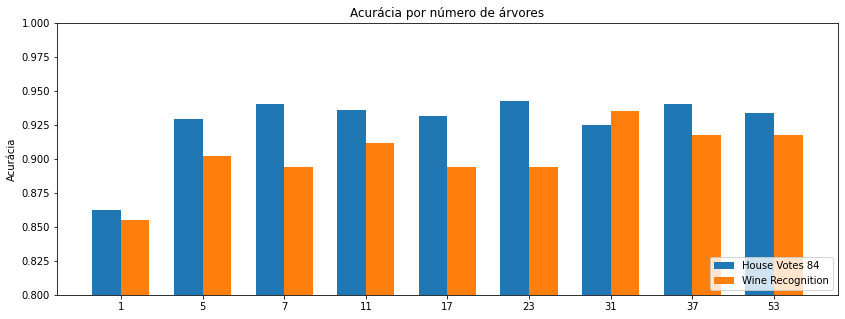

In [14]:
figure(figsize=(14,5))

N = 9
house_votes_84 = results['house_votes_84'].values()
wine_recognition = results['wine_recognition'].values()

ind = np.arange(N)
width = 0.35
plt.bar(ind, house_votes_84, width, label='House Votes 84')
plt.bar(ind + width, wine_recognition, width, label='Wine Recognition')

plt.ylabel('Acurácia')
plt.title('Acurácia por número de árvores')

plt.xticks(ind + width / 2, ('1', '5', '7', '11', '17', '23', '31', '37', '53'))
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.show()

### Considerações de desempenho (tempo) do modelo

Há pelo menos dois pontos com espaço de melhora evidente em nossa implementação. O primeiro ponto é uma questão de "baixo nível" da implementação da validação cruzada. Ao invés de usarmos uma lista de de índices, poderíamos usar uma estrutura de árvore balanceada, que nos proporcionaria tempo de acesso O(logn), em oposição ao tempo de acesso O(n) de uma lista comum. O segundo ponto é uma questão do algoritmo em si: a nossa implementação não faz poda de árvores, o que poderia melhorar bastante o desempenho do modelo para fazer predições e, como bônus, teríamos maior poder de generalização.